<a href="https://colab.research.google.com/github/yoonkim97/pytorch-resnet-mnist/blob/master/MNISTResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import urllib
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler

In [2]:

num_workers = 0
batch_size = 20
basepath = '.'

def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
    opener.retrieve(
    url, f'{basepath}/{filename}')

set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  from ipykernel import kernelapp as app


In [0]:
class MnistResNet(ResNet):
  def __init__(self):
    super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  def forward(self, x):
    return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
train_label_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
test_label_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def get_same_indices(target, labels):
  label_indices = []
  for i in range (len(target)):
    for j in range (len(labels)):
      if target[i] == labels[j]:
        label_indices.append(i)
  return label_indices

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
  mnist = MNIST(download=True, train=True, root=".").train_data.float()
    
  data_transform = Compose([Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

  train_dataset = MNIST(download=True, root=".", transform=data_transform, train=True)
  train_indices = get_same_indices(train_dataset.targets, train_label_classes)
  train_loader = DataLoader(dataset = train_dataset, batch_size=train_batch_size, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))

  val_dataset = MNIST(download=False, root=".", transform=data_transform, train=False)
  # val_indices = get_same_indices(val_dataset.targets, test_label_classes)
  val_classes = [100, 100, 100, 100, 100, 100, 100, 100, 100, 13]
  weights = 1 / torch.Tensor(val_classes)
  val_loader = DataLoader(dataset = val_dataset, batch_size=val_batch_size, shuffle=False, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, val_batch_size))
  return train_loader, val_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [19]:
start_ts = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 5

model = MnistResNet().to(device)
train_loader, val_loader = get_data_loaders(256, 256)

losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

#training loop
# for epoch in range(epochs):
#     total_loss = 0
#     progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
#     model.train()
    
#     for i, data in progress:
#         X, y = data[0].to(device), data[1].to(device)
#         model.zero_grad()
#         outputs = model(X)
#         loss = loss_function(outputs, y)

#         loss.backward()
#         optimizer.step()
#         current_loss = loss.item()
#         total_loss += current_loss
#         progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
#     torch.cuda.empty_cache()
    
#     print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}")
#     losses.append(total_loss/batches)
#     print(losses)
#     print(f"Training time: {time.time()-start_ts}s")
#     model_filename = 'model.pth'
#     torch.save(model.state_dict(), model_filename)

val_losses = 0
precision, recall, f1, accuracy = [], [], [], []

confusion_actuals = []
probabilities = []
predictions = []
roc_actuals = []

which_class = 9

model.load_state_dict(torch.load("/content/model.pth"))
# validation loop
model.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        y_np = y.cpu().numpy()

        x_val_zeros = X[y_np == 0]
        x_val_ones = X[y_np== 1]
        x_val_twos = X[y_np == 2]
        x_val_threes = X[y_np == 3]
        x_val_fours = X[y_np == 4]
        x_val_fives = X[y_np == 5]
        x_val_sixes = X[y_np == 6]
        x_val_sevens = X[y_np == 7]
        x_val_eights = X[y_np == 8]
        x_val_nines = X[y_np == 9]

        print(len(x_val_zeros), len(x_val_ones), len(x_val_twos), len(x_val_threes), len(x_val_fours), len(x_val_fives), len(x_val_sixes), len(x_val_sevens), len(x_val_eights), len(x_val_nines))
        outputs = model(X)
        prediction = outputs.argmax(dim=1, keepdim=True)
        confusion_actuals.extend(y.view_as(prediction))
        roc_actuals.extend(y.view_as(prediction) == which_class)
        probabilities.extend(np.exp(outputs.cpu()[:, which_class]))  
        predictions.extend(prediction)

        val_losses += loss_function(outputs, y)

        predicted_classes = torch.max(outputs, 1)[1]
        
        for acc, metric in zip((precision, recall, f1, accuracy), 
                                (precision_score, recall_score, f1_score, accuracy_score)):
            acc.append(
                calculate_metric(metric, y.cpu(), predicted_classes.cpu())
            )

confusion_actuals = [i.item() for i in confusion_actuals]
predictions = [i.item() for i in predictions]
roc_actuals = [i.item() for i in roc_actuals]
class_probabilities = [i.item() for i in probabilities]

confusion_mtrx = confusion_matrix(confusion_actuals, predictions)

FP = confusion_mtrx.sum(axis=0) - np.diag(confusion_mtrx)  
FN = confusion_mtrx.sum(axis=1) - np.diag(confusion_mtrx)
TP = np.diag(confusion_mtrx)
TN = confusion_mtrx.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)

print(confusion_mtrx)
print("FP", FP)
print("FN", FN)
print("TP", TP)
print("TN", TN)

print("TPR", TPR)
print("FPR", FPR)

# plt.plot(FPR, TPR)
# plt.show()
# auc = np.trapz(TPR,FPR)
# print('auc', auc)
# fpr, tpr, _ = roc_curve(roc_actuals, class_probabilities)
# print("actuals", roc_actuals)
# print("class_probabilities", class_probabilities)
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# plt.figure()
# lw = 2 
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for digit=%d class' % which_class)
# plt.legend(loc="lower right")
# plt.show()    
print_scores(precision, recall, f1, accuracy, val_batches)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


13 36 13 0 41 17 0 12 0 124
[[ 13   0   0   0   0   0   0]
 [  0  36   0   0   0   0   0]
 [  0   0  13   0   0   0   0]
 [  0   0   0  41   0   0   0]
 [  0   0   0   0  17   0   0]
 [  0   0   0   0   0  12   0]
 [  0   0   0 124   0   0   0]]
FP [  0   0   0 124   0   0   0]
FN [  0   0   0   0   0   0 124]
TP [13 36 13 41 17 12  0]
TN [243 220 243  91 239 244 132]
TPR [1. 1. 1. 1. 1. 1. 0.]
FPR [0.         0.         0.         0.57674419 0.         0.
 0.        ]
	     precision: 0.7498
	        recall: 0.8571
	            F1: 0.7712
	      accuracy: 0.5156


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    def set_temperature(self, valid_loader):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()
        anomaly_criterion = _AnomalyDetection().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        # before_temperature_nll = nll_criterion(logits, labels).item()
        # before_temperature_ece = ece_criterion(logits, labels).item()
        # print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_anomaly = anomaly_criterion(self.temperature_scale(logits), labels)
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))
        print('Anomaly Count: %d' %after_temperature_anomaly)
        return self

NameError: ignored

In [0]:
class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
      with torch.no_grad():
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
    
      ece = torch.zeros(1, device=logits.device)
      for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
          # Calculated |confidence - accuracy| in each bin
          in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
          prop_in_bin = in_bin.float().mean()
          if prop_in_bin.item() > 0:
              accuracy_in_bin = accuracies[in_bin].float().mean()
              avg_confidence_in_bin = confidences[in_bin].mean()
              ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

      return ece

In [0]:
class _AnomalyDetection(nn.Module):
  def __init__(self):
    super(_AnomalyDetection, self).__init__()
  def forward(self, logits, labels):
    with torch.no_grad():
      softmaxes = F.softmax(logits, dim=1)
      confidences, predictions = torch.max(softmaxes, 1)
      accuracies = predictions.eq(labels)

    predictions_list = predictions.cpu().numpy()
    confidences_list = confidences.cpu().numpy()
    actuals_list = labels.cpu().numpy()

    all_triples = []
    anomaly_triples = []
    modified_anomaly_triples = []

    anomaly_count = 0
    for i in range(len(actuals_list)):
      all_triples.append((i, actuals_list[i], predictions_list[i], confidences_list[i]))
      if (confidences_list[i] < 0.7):
        anomaly_triples.append((i, actuals_list[i], predictions_list[i], confidences_list[i]))
        if (actuals_list[i] == 9):
          predictions_list[i] = 9
          modified_anomaly_triples.append((i, actuals_list[i], predictions_list[i], confidences_list[i]))
        anomaly_count += 1
    print("all triples : ", all_triples)
    # print("length of all triples: ", len(all_triples))
    print("anomaly triples: ", anomaly_triples)
    # print("length of anomaly triples: ", len(anomaly_triples))
    print("modified anomaly triples:", modified_anomaly_triples)
    # print(len(anomaly_triples))
    # print(len(modified_anomaly_triples))

    conf_matrix = confusion_matrix(actuals_list, predictions_list)
    precision = precision_score(actuals_list, predictions_list, average='macro')
    recall = recall_score(actuals_list, predictions_list, average='macro')
    f1 = f1_score(actuals_list, predictions_list, average='macro')
    print(conf_matrix) 
    print("Precision: %d", precision)
    print("Recall: %d", recall)
    print("F1 Score: %d", f1)
    

    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)
    ACC = (TP+TN)/(TP+FP+FN+TN)

    # # Sensitivity, hit rate, recall, or true positive rate
    # TPR = TP/(TP+FN)
    # # Specificity or true negative rate
    # TNR = TN/(TN+FP) 
    # # Precision or positive predictive value
    # PPV = TP/(TP+FP)
    # # Negative predictive value
    # NPV = TN/(TN+FN)
    # # Fall out or false positive rate
    # FPR = FP/(FP+TN)
    # # False negative rate
    # FNR = FN/(TP+FN)
    # # False discovery rate
    # FDR = FP/(TP+FP)

    # # Overall accuracy
    # ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return anomaly_count

all triples :  [(0, 4, 4, 0.79839295), (1, 1, 1, 0.7983928), (2, 4, 4, 0.79839295), (3, 5, 5, 0.7980337), (4, 9, 4, 0.6371158), (5, 9, 4, 0.6371139), (6, 4, 4, 0.79839295), (7, 9, 4, 0.6371139), (8, 1, 1, 0.7983928), (9, 5, 5, 0.7980337), (10, 9, 4, 0.6371158), (11, 1, 1, 0.7983921), (12, 9, 4, 0.6371158), (13, 9, 4, 0.52998406), (14, 9, 4, 0.5299846), (15, 9, 4, 0.6371139), (16, 7, 7, 0.79839295), (17, 5, 5, 0.7980337), (18, 4, 4, 0.79839295), (19, 9, 4, 0.6371139), (20, 5, 5, 0.7980337), (21, 9, 4, 0.6371139), (22, 9, 4, 0.6371158), (23, 9, 4, 0.6371139), (24, 0, 0, 0.79839224), (25, 4, 4, 0.79839295), (26, 9, 4, 0.6371158), (27, 4, 4, 0.79839295), (28, 4, 4, 0.79839295), (29, 9, 4, 0.6371139), (30, 9, 4, 0.6371158), (31, 4, 4, 0.79839295), (32, 4, 4, 0.79839295), (33, 4, 4, 0.79839295), (34, 1, 1, 0.7983928), (35, 9, 4, 0.6371139), (36, 9, 4, 0.6371158), (37, 9, 4, 0.6371139), (38, 9, 4, 0.6371158), (39, 9, 4, 0.6371139), (40, 1, 1, 0.7983928), (41, 9, 4, 0.6371139), (42, 9, 4, 0.63

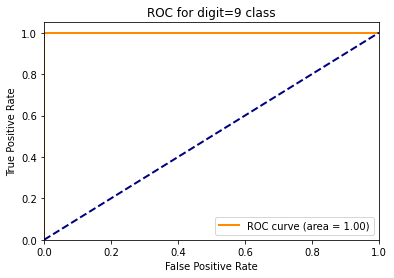

Temperature scaled model saved to %s model_with_temperature.pth
Done!


In [87]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(val_loader)


anomaly_class = 9 
actuals = []
class_probabilities = []
# # for i in range(len(actuals_list)):
# #   if (actuals_list[i] == anomaly_class):
# #     actuals.append(True)
# #   else:
# #     actuals.append(False)

scaled_model.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        print(y.cpu().numpy())
        outputs = scaled_model(X)
        prediction = outputs.argmax(dim=1, keepdim=True)
        actuals.extend(y.view_as(prediction) == anomaly_class)
        class_probabilities.extend(np.exp(outputs.cpu()[:, anomaly_class])) 
      
print(class_probabilities)
# print("prediction", prediction)
# print("prediction len", len(prediction))
# print("actual len", len(actuals))

actuals = [i.item() for i in actuals]
probabilities = [i.item() for i in class_probabilities]

fpr, tpr, _ = roc_curve(actuals, probabilities)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()
model_filename = 'model_with_temperature.pth'
torch.save(scaled_model.state_dict(), model_filename)
print('Temperature scaled model saved to %s', model_filename)
print('Done!')